# NEGF CNT Simulation Environment
This work was initially developed during my semester project at the Micro and Nanosystem Group of ETH Zurich. It was initially implemented in MatLAB and here's the revised version in Python. 
### To do
- get constants from library or global variables
- make one class
- implement the Kati potential
- In the Hamiltonian, the Gate Voltage has to be calculated by the total charge of the CNT, which comes from the NEGF solver (it's part of the self-consistent big solver to do)
### Bugs
- Energy reference not clear
### Hints/Strategy


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import spdiags


e = 1.6e-19        # Elementary charge [C]
k = 8.6e-5        # Boltzmann constant [eV/K]
h = 4.135e-15     # Plank's constant[eV*s]
kB = 8.6e-5       # Boltzmann constant [eV*K]

#SELECT
contacts = 1 # 1:metallic, 2:infinite CNT, 3:hard wall

class CNT:
    
    def __init__(self,L=20,d=2,eta = 1E-8,T = 300 , contacts = 1, \
                 Emin =-2,Emax = 2,dE = 0.001, Vd = 0.3, Vs = 0, Vgmax = 3, Vgmin = -3, dVg = 0.5, phiB = 0.35, Vbi = 0.35):

        N_ini = round(L/0.142+1)
        self.N = N_ini if (N_ini % 2) == 0 else N_ini + 1 # N must be even
        self.n = round(1+np.pi*d/0.143/np.sqrt(3))        # number of C atoms in a ring
        self.L = (self.N-1)*0.142                         # CNT length [nm]
        self.d = (self.n-1)*0.143*np.sqrt(3)/np.pi        #CNT diameter [nm]
        self.x = np.linspace(0,self.L,self.N)             # 1D-spatial coordinate x
        self.Eg = 0.8/self.d                              #Energy Gap [eV]
        self.modes = [round(2*self.n/3),round(2*self.n/3)+1 ,round(2*self.n/3)+2 ]
        self.contacts = contacts
        self.dE = dE
        self.NE = round((Emax-Emin)/self.dE+1)            #number of energy point
        self.E = np.linspace(Emin,Emax,self.NE)  #Energy Vector
        self.eta = eta                      #simulation parameter for small imag part to energy
        self.T = T                          #Temperature [K]
        self.Vd = Vd
        self.Vs = Vs
        self.Vgv = np.linspace(Vgmin,Vgmax,round((Vgmax-Vgmin)/dVg+1))
        self.phiB = phiB
        self.Vbi = Vbi


class Parameters:
    def __init__(self, eta = 1E-8,T = 300 ,Emin =-2,Emax = 2,dE = 0.001, Vd = 0.3, Vs = 0, Vgmax = 3, Vgmin = -3, dVg = 0.5):
 
        self.dE = dE
        self.NE = round((Emax-Emin)/self.dE+1)            #number of energy point
        self.E = np.linspace(Emin,Emax,self.NE)  #Energy Vector
        self.eta = eta                      #simulation parameter for small imag part to energy
        self.T = T                          #Temperature [K]
        self.Vd = Vd
        self.Vs = Vs
        self.Vgv = np.linspace(Vgmin,Vgmax,round((Vgmax-Vgmin)/dVg+1))


## Electrostatic Potential (Initial Guess)

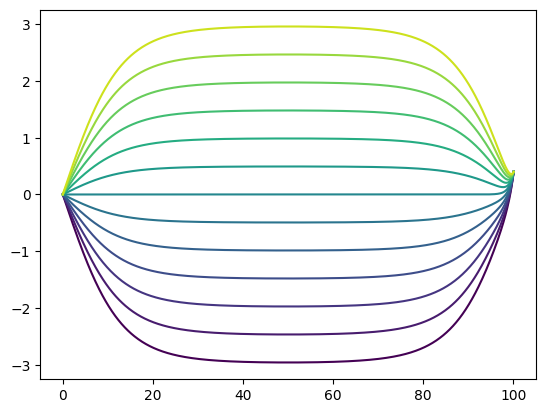

In [2]:
#Laplace Problem 
#Vd, Vs, Vg [V] 
import pandas as pd
from matplotlib import colormaps


def Laplace_Potential(CNT):
    
    x = CNT.x
    Vd = CNT.Vd
    Vs = CNT.Vs
    Vgv = CNT.Vgv
    Vtot = np.zeros([len(x),len(Vgv)])

    #External Potentials
    VextS = np.exp(-x)           #VextS                   
    VextD = np.exp((x-x[-1]))    #VextD       
    VextG = np.tanh(2.5*np.sin(x*np.pi/x[-1]))*0.5 #VextG

    for i,Vg in enumerate(Vgv):
        Vtot[:,i] = (2*Vs*VextS + 2*Vd*VextD + 2*Vg*VextG)
    
    return Vtot,Vgv, Vs, Vd

#Test
myCNT = CNT(L=100,d=2,eta = 1E-8,T = 300 , contacts = 1, \
                 Emin =-3,Emax = 3,dE = 0.01, Vd = 0.2, Vs = 0, Vgmax = 3, Vgmin = -3, dVg = 0.5)

Vtot,Vgv, Vs, Vd = Laplace_Potential(myCNT)

viridis = colormaps['viridis']
fig,ax = plt.subplots()
for i,Vg in enumerate(Vgv):
    plt.plot(myCNT.x,Vtot[:,i],color = viridis(i/len(Vgv)))

## Hamiltonian
The Mode-Space Tight-Binding Hamiltonian describes only the modes responsible for electronic transport and the size of the Hamiltonian matrix will be Nm,Nm where m = number of modes.

$n$ : number of C atoms in a ring

$k_t= 2\pi q/C$ where $q$ is an integer between $0 \le q <= n-1$

$b_{2q} = 2t \cos{(\pi q/n)}$

$$\tilde{H}=
\begin{pmatrix}
V_1 && b_{2q} && \cdots && 0\\
b_{2q} && V_2 && t && 0\\
0      && t && V_3 && b_{2q}
\end{pmatrix}
$$

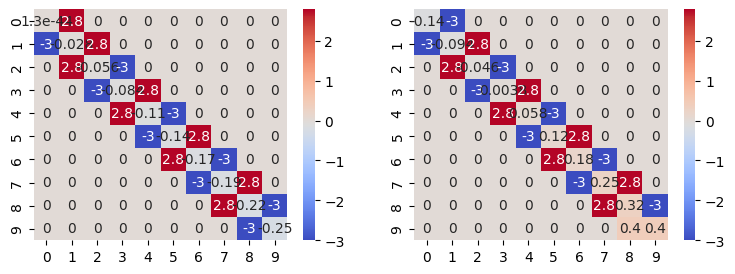

In [3]:
def Discrete_Hq(V,CNT,q,c ):
    #--------Mode Space Tight-Binding Hamiltonian-----------
    #
    # inputs:
    # V : Total Electrostatic Potential accross the CNT (N,1)
    # N : number of rings in the CNT (scalar)                
    # n : numper of C atoms in a ring (scalar)
    #
    # outputs:
    # H : Hamiltonian Matrix (N,N)
    # b2q : computed from the tight-binding formulation (scalar)

    N = CNT.N
    t=-3                        # pz coupling parameter [eV]
    b2q = 2*t*np.cos(np.pi*q/CNT.n)
    H = np.zeros([N,N])
    
    if c == False:
        U = V
    else:
        U = V*c
    
    for i in range(1,N-1):
        
        H[i,i] = U[i]
        if np.mod(i,2) == 0 : #i is even, B-type ring
            H[i,i+1] = t
            H[i,i-1] = b2q
        
        elif np.mod(i,2) == 1: #i is odd, A-type ring
            H[i,i+1] = b2q
            H[i,i-1] = t

    H[0,0] = U[0]
    H[0,1] = b2q
    
    H[N-1,N-1] = U[N-1]
    H[N-1,N-2] = H[N-1,N-1]
 
    return H,b2q


#Test
myCNT = CNT(L=100,d=2,eta = 1E-8,T = 300 , contacts = 1, \
                 Emin =-3,Emax = 3,dE = 0.01, Vd = 0.2, Vs = 0, Vgmax = 2, Vgmin = -2, dVg = 0.5)
modes = myCNT.modes
H,b2q = Discrete_Hq(Vtot[:,1],myCNT,modes[0],c=1)

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (9,3))
sns.heatmap(H[0:10,0:10],cmap='coolwarm',annot=True,ax = ax1)
sns.heatmap(H[myCNT.N-10:myCNT.N,myCNT.N-10:myCNT.N],cmap='coolwarm',annot=True,ax = ax2)
plt.show()

## Self-Energies

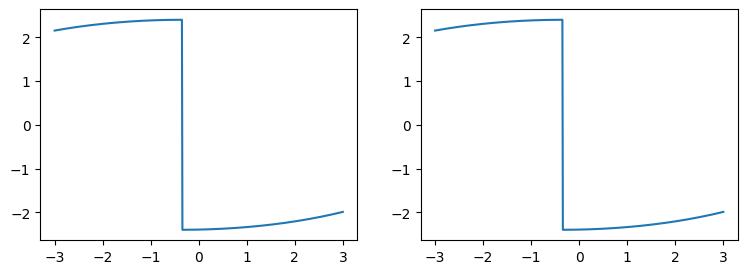

In [6]:
def Contacts_Sigma_Functions(CNT,Hq,b2q):#,eta,EfS,EfD,Vb):

    E = CNT.E
    NE = CNT.NE
    #Eg = CNT.Eg            #CNT band-gap [eV] TO DELETE (IT DOESN`T MATTER)
    contacts = CNT.contacts
    #phiB = 0.5*Eg - Vb  #Schottky barrier [eV]
    eta = CNT.eta

    
    t = -3              #tight-binding parameter [eV]
    alpha = 0.8         #Coupling parameter 0<alpha<1

    SigmaS= np.zeros(NE,dtype = 'complex_')
    SigmaD = np.zeros(NE,dtype = 'complex_')
    
    match contacts:
        case 1: #metal contacts

            Emd = - CNT.Vbi -e*CNT.Vd
            Ems = - CNT.Vbi  -e*CNT.Vs# Source middle-gap energy [eV]
            
            SigmaS = 0.5*alpha*(E+1j*eta-Ems-np.sqrt((E+1j*eta-Ems)**2-4*t**2)) #Source self-energy
            SigmaD = 0.5*alpha*(E+1j*eta-Emd-np.sqrt((E+1j*eta-Emd)**2-4*t**2)) #Drain self-energy
            
        
        case 2: #infinite CNT
            for i in range(len(E)):
                
                eqn11 = ((E[i]+1j*eta-Hq[1,1])**2+t**2-b2q**2+np.sqrt(((E[i]+1j*eta-Hq[1,1])**2+t**2-b2q**2)**2 \
                -4*t**2*(E[i]+1j*eta-Hq[1,1])**2))/(2*t**2*(E[i]+1j*eta-Hq[1,1]))
                
                eqn21 = ((E[i]+1j*eta-Hq[1,1])**2+t**2-b2q**2-np.sqrt(((E[i]+1j*eta-Hq[1,1])**2+t**2-b2q**2)**2 \
                -4*t**2*(E[i]+1j*eta-Hq[1,1])**2))/(2*t**2*(E[i]+1j*eta-Hq[1,1]))
                
               # if np.imag(eqn11) <= 0:
               #     g1 = eqn11
               #         
               # elif np.imag(eqn21) < 0:
               #     g1 = eqn21
#
                if np.imag(eqn11)< np.imag(eqn21):
                    g1 = eqn11
                else:
                    g1 = eqn21
                
                SigmaS[i] = g1*t**2
                SigmaD[i] = SigmaS[i]
        
    return SigmaS,SigmaD

#Test

SigmaS,SigmaD = Contacts_Sigma_Functions(myCNT,H,b2q) #,eta,EfS,EfD,Vb)

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (9,3))
#ax1.plot(myCNT.E,np.real(SigmaD))
#ax1.plot(myCNT.E,np.imag(SigmaD))
ax1.plot(myCNT.E,np.imag(SigmaD))
#ax2.plot(myCNT.E,np.real(SigmaS))
#ax2.plot(myCNT.E,np.imag(SigmaS))
ax2.plot(myCNT.E,np.imag(SigmaS))

In [39]:
def solve_transport_negf(CNT, V,contacts,recursive = True):

    N = CNT.N
    n = CNT.n
    x = CNT.x
    vB = CNT.Vbi
    E = CNT.E
    dE = CNT.dE
    NE = CNT.NE

    T = CNT.T
    
    dx = x[2]-x[1]                                        #discretization of the spatial dimension
    eta = CNT.eta       
    modes = [round(2*n/3),round(2*n/3)+1 ,round(2*n/3)+2 ] #modes vector

    #Initialize variables
    gEL = np.zeros([NE,N,len(modes)],dtype = 'complex_')  #DOS induced from the left contact
    gER = np.zeros([NE,N,len(modes)],dtype = 'complex_') #DOS induced from the right contact                           
    Idq = np.zeros(len(modes))
    Id = 0
    TEL = np.zeros([NE,len(modes)])
    TER = np.zeros([NE,len(modes)])
    
    #FERMI PROBABILITY FUNCTIONS
    fS = 1/(1 + np.exp((E-CNT.Vs)/(k*T)))
    fD = 1/(1 + np.exp((E-CNT.Vd)/(k*T)))
    
    #Loop over the modes
    for j,q in enumerate(modes):
        
        H,b2q = Discrete_Hq(V,CNT,q,False)                                                  #get Hamiltonian
        
        SigmaR11,SigmaRNN = Contacts_Sigma_Functions(CNT,H,b2q)#,eta,EfS,EfD,Vb) #get self-energies
        
        Gamma11 = 1j*(SigmaR11-np.conjugate(SigmaR11))/2                                #get Gamma functions
        GammaNN = 1j*(SigmaRNN-np.conjugate(SigmaRNN))/2


        #Recursive Algorithm
        if recursive == True:
            
            E = E+1j*eta              #adding eta to evergy vector
    
            #Initialize retarded functions
            gR = np.zeros([NE,N],dtype = 'complex_')
            GR = np.zeros([NE,N],dtype = 'complex_')
            GRn1 = np.zeros([NE,N],dtype = 'complex_')
    
            # 1) calculate gR at the last point x[N-1]
            gR[:,N-1] = 1 / (E - H[N-1,N-1] - SigmaRNN) 
    
            # 2) propagate back gR back until x[1]
            for i in reversed(range(1,N-1)):
                gR[:,i] = 1 / (E - H[i,i] - H[i,i+1] * gR[:,i+1] * H[i+1,i]) ###CHECK THE INDECES
                    
            # 3) calculate GR and GRn1 at x[0]
            GR[:,0] = 1 / (E - H[0,0] - H[0,1] * gR[:,1] * H[1,0] - SigmaR11)
            GRn1[:,0] = GR[:,0]
    
            # 4) propagate forward and calculate GR and GRn1 till x[N-1]
            for i in range(1,N):
                GR[:,i] = gR[:,i] + H[i,i-1] * GR[:,i-1] * H[i-1,i] * gR[:,i]**2
                GRn1[:,i] = gR[:,i] * H[i,i-1] * GRn1[:,i-1]
    
            #calculate DOS
            gEL[:,:,j] = (GRn1.T**2 * Gamma11).T/ (2 * np.pi * 0.142*1E-9)
            gER[:,:,j] = (1j * (GR - np.conjugate(GR))) / (2 * np.pi *0.142*1E-9) - gEL[:,:,j]
    
            #Transmission
            #TER[:,j] = np.abs(GRn1[:,N-1]**2*Gamma11*GammaNN).T

            TER[:,j] = np.abs(GRn1[:,N-1]**2*Gamma11*GammaNN).T
            #TER[:,k] = np.real(GR[:,N-1]**2*Gamma11*GammaNN).T
            TEL[:,j] = TER[:,j]
            #TER[:,k] = np.real(GRn1[:,0]**2*Gamma11*GammaNN).T
            
            E = E-1j*eta              #remove eta to evergy vector ??

        #Direct matrix inversion (slow)
        else:
            Sigma = np.zeros([N,N],dtype = 'complex_')

            for i in range(NE):
                Sigma[0,0] = SigmaR11[i]
                Sigma[N-1,N-1] = SigmaR11[i]

                
                D = spdiags(np.ones(N), 0, N,N,format='csc')
                M = (E[i] + 1j * eta) * D - H - Sigma
                GR = np.linalg.inv(M)

                #hard-wall scenario, analitical solution
                if contacts == 3:
                    gEL[i,:,j] = np.real(1/(2*np.pi*dx*1e-9))*np.abs(np.diagonal(GR-np.conjugate(GR)))
                    
                else:
                    gEL[i,:,j] = np.real(1/(2*np.pi*dx*1e-9)*(GR[:,0]*Gamma11[i])).T
                    gER[i,:,j] = np.real(1/(2*np.pi*dx*1e-9)*(GR[:,N-1]*GammaNN[i])).T
                    
                #TEL[i,k] = np.real(GR[0,N-1]**2*Gamma11[i]*GammaNN[i]).T
                #TER[i,k] = np.real(GR[N-1,0]**2*Gamma11[i]*GammaNN[i]).T
                TER[i,j] = np.abs(GR[0,N-1]**2*Gamma11[i]*GammaNN[i]).T
                TEL[i,j] = np.abs(GR[N-1,0]**2*Gamma11[i]*GammaNN[i]).T
                
                GRn1 = 0   
                
        E = E-1j*eta

                
        
    
    
        #Current Modal Contribution
        Idq[j] = np.abs(np.sum(4*e*np.dot((fS-fD),TEL[:,j])*dE/h))
        Id +=  Idq[j]
    
    #Total DOS
    gEL_ = np.sum(gEL,axis = 2)
    gER_ = np.sum(gER,axis = 2)
    
    #Total Current
    #Id = np.sum(Idq)
    return gEL_,gER_,TEL,Id,GR,GRn1


#Test


# LDOS and Transmission
The Local Density Of States (LDOS) and the Transmission are calculated from the retarded Green Functions in the <code>solve_transport_negf</code> function. 

Text(0.5, 1.0, 'Fermi Distributions')

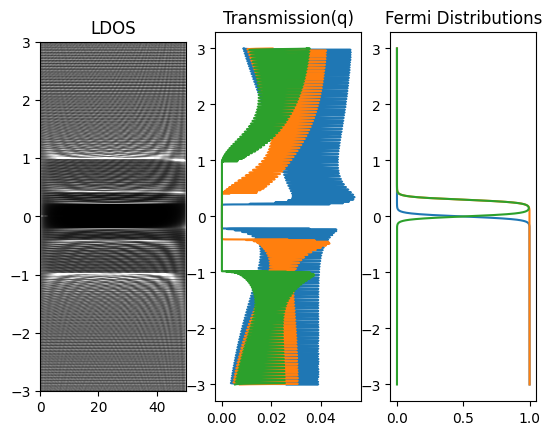

In [40]:
myCNT = CNT(L=50,d=2,eta = 1E-8,T = 300 , contacts = 1, \
                 Emin =-3,Emax = 3,dE = 0.001, Vd = 0.3, Vs = 0, Vgmax = 1, Vgmin = -1, dVg = 0.1)

Utot,Ugv,Vs,Vd = Laplace_Potential(myCNT)
gEL,gER,TEL,Id,GR, GRn1 = solve_transport_negf(myCNT, Utot[:,round(0.5*np.shape(Utot)[1])],contacts,recursive = True)


#FERMI PROBABILITY FUNCTIONS
fS = 1/(1+np.exp((myCNT.E-myCNT.Vs)/(k*myCNT.T)))
fD = 1/(1+np.exp((myCNT.E-myCNT.Vd)/(k*myCNT.T)))
#ELECTRON DENSITY
ne = (gEL.T*fS).T + (gER.T*fD).T
nh = (gEL.T*(1-fS)).T + (gER.T*(1-fD)).T

ne_tot = (np.sum(ne, axis = 0)+np.sum(nh,axis =0))*myCNT.dE
#plt.plot(myCNT.x,np.abs(ne_tot))

LDOS = np.abs(gEL+gER)

x = myCNT.x
y = myCNT.E
extent = np.min(x), np.max(x), np.min(y), np.max(y)
#plt.imshow(np.abs(ne),"gray",aspect = 20,vmin=0, vmax=2e9, extent = extent)

fig,(ax1,ax2,ax3) =plt.subplots(1,3)

ax1.imshow(LDOS,"gray",aspect = 20,vmin=0, vmax=3e9, extent = extent)
ax1.set_title("LDOS")
ax2.plot(TEL,myCNT.E)
ax2.set_title("Transmission(q)")
ax3.plot(fS,myCNT.E)
ax3.plot(fD,myCNT.E)
ax3.plot(fD-fS,myCNT.E)
ax3.set_title("Fermi Distributions")

# I-V Curve

In [41]:
myCNT = CNT(L=50,d=2,eta = 1E-8,T = 300 , contacts = 1, \
                 Emin =-3,Emax = 3,dE = 0.001, Vd = 0.3, Vs = 0, Vgmax = 1, Vgmin = -1, dVg = 0.1)

Utot,Ugv,Vs,Vd = Laplace_Potential(myCNT)

#INITIATING CURRENT VECTOR
Id_Ug = np.zeros(len(Ugv))

#I-V characteristics:  loop over the gate potentials
for i,Ug in enumerate(Ugv):
    V = Utot[:,i]
    
    #solve the non-equilibrium Green Functions
    gEL,gER,TEL,Id,GR, GRn1 = solve_transport_negf(myCNT, V,contacts,recursive = True)
    #store current for gate voltage Ug in Ugv
    Id_Ug[i] = Id

Text(0.5, 1.0, 'I-V Curve')

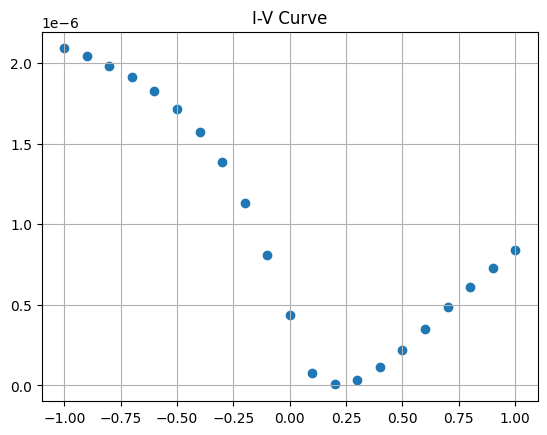

In [42]:
plt.grid(True)
plt.scatter(Ugv,Id_Ug)
plt.title("I-V Curve")

# Check the Recursive Algorithm
We can check if the recursive algorithm produces the same results of the direct inversion by looking at the GR functions. 
NOTE: the inversion takes a long time to run! --> Use a small data set!

In [43]:
myCNT_Test = CNT(L=10,d=2,eta = 1E-8,T = 300 , contacts = 1, \
                 Emin =-3,Emax = 3,dE = 0.5, Vd = 0.3, Vs = 0, Vgmax = 1, Vgmin = -1, dVg = 0.5)


Utot,Ugv,Vs,Vd = Laplace_Potential(myCNT_Test)

#DRAIN AND SOURCE FERMI LEVEL
EfD = Vb-Vd
EfS = Vb-Vs

#INITIATING CURRENT VECTOR
Id_Ug = np.zeros(len(Ugv))
Id_Ug_Rec = np.zeros(len(Ugv))

#I-V characteristics:  loop over the gate potentials
for i,Ug in enumerate(Ugv):
    V = Utot[:,i]
    
    #solve the non-equilibrium Green Functions with Recursive and direct inversion
    gEL,gER,TEL,Id,GR, GRn1 = solve_transport_negf(myCNT_Test, V,contacts,recursive = False)
    gEL_Rec,gER_Rec,TEL_Rec,Id_Rec,GR_Rec,GRn1_Rec = solve_transport_negf(myCNT_Test, V,contacts,recursive = True);

    #store current for gate voltage Ug in Ugv
    Id_Ug[i] = Id
    Id_Ug_Rec[i] = Id_Rec

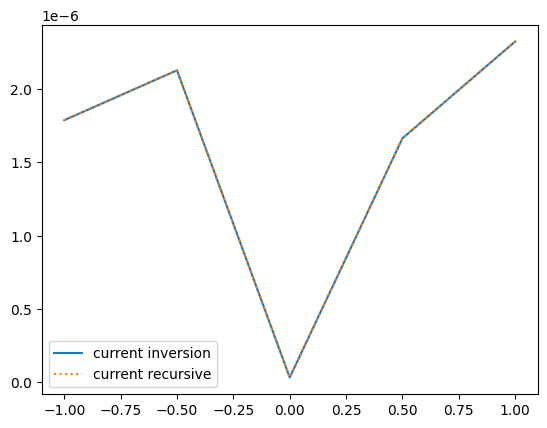

In [46]:
plt.plot(Ugv,Id_Ug)
plt.plot(Ugv,Id_Ug_Rec,linestyle = ":")
plt.legend(["current inversion","current recursive"])

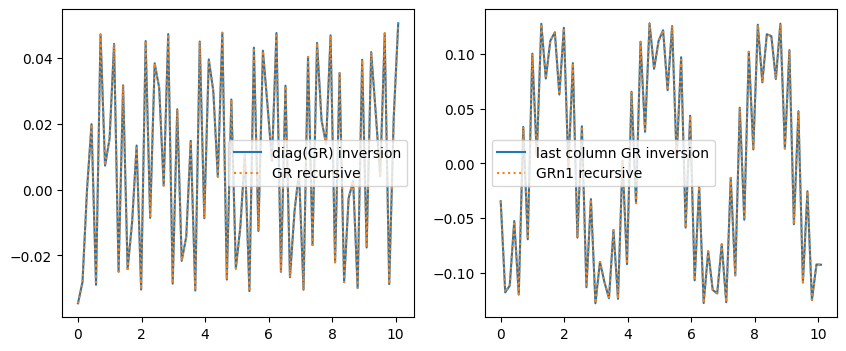

In [37]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (10,4))
ax1.plot(myCNT_Test.x,np.diag(np.real(GR)))
ax1.plot(myCNT_Test.x,np.real(GR_Rec[-1,:]),linestyle = ":")
ax1.legend(["diag(GR) inversion","GR recursive"])
ax2.plot(myCNT_Test.x,np.real(GR[:,0]))
ax2.plot(myCNT_Test.x,np.real(GRn1_Rec[-1,:]),linestyle = ":")
ax2.legend(["last column GR inversion","GRn1 recursive"])

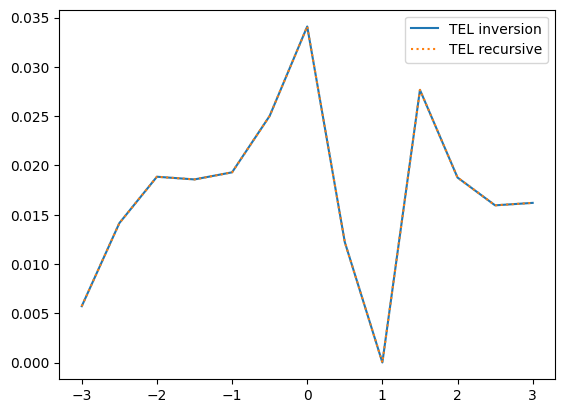

In [48]:
TEL_offset = TEL-TEL_Rec
q=1
plt.plot(myCNT_Test.E,TEL[:,q])
plt.plot(myCNT_Test.E,TEL_Rec[:,q],linestyle = ":")
plt.legend(["TEL inversion","TEL recursive"])

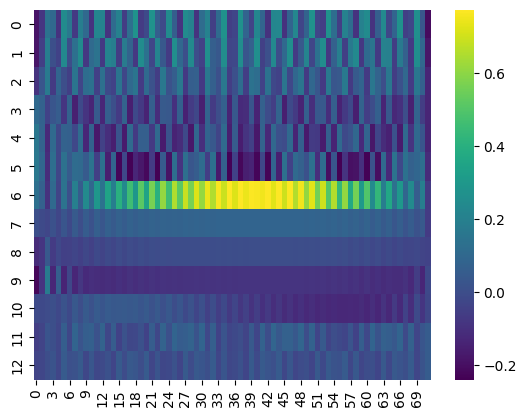

In [35]:
qnty = GR_Rec

fig,ax1 = plt.subplots()
try:
    sns.heatmap(np.real(qnty),cmap='viridis',annot=False,ax = ax1)
    #sns.heatmap(np.imag(qnty[N-10:N,N-10:N]),cmap='coolwarm',annot=True,ax = ax2)
except ValueError:  #raised if `y` is empty.
    pass

plt.show()